# Importando as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy  as np
import pickle
import matplotlib.pyplot as plt
import itertools

# utilizado para a criação da barra de status
from tqdm import tqdm

# funções utilizadas para tratamento dos dados
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# algoritmos utilizados
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# métricas utilizadas para avalidar o modelo
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, f1_score

from os.path  import dirname, abspath, join

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Importando os dados

In [2]:
# definindo os tipos de dados para importação
dtype={"id_osc": int, "cd_natureza_juridica_osc": object, 
       "ft_natureza_juridica_osc": object, "tx_razao_social_osc": object, 
       "ft_razao_social_osc": object, "tx_nome_fantasia_osc": object, 
       "ft_nome_fantasia_osc": object, "im_logo": object, "ft_logo": object, 
       "tx_missao_osc": object, "ft_missao_osc": object, "tx_visao_osc": object, 
       "ft_visao_osc": object, "dt_fundacao_osc": object, 
       "ft_fundacao_osc": object, "dt_ano_cadastro_cnpj": object, 
       "ft_ano_cadastro_cnpj": object, "tx_sigla_osc": object, 
       "ft_sigla_osc": object, "tx_resumo_osc": object, "ft_resumo_osc": object, 
       "cd_situacao_imovel_osc": object, "ft_situacao_imovel_osc": object, 
       "tx_link_estatuto_osc": object, "ft_link_estatuto_osc": object, 
       "tx_historico": object, "ft_historico": object, 
       "tx_finalidades_estatutarias": object, "ft_finalidades_estatutarias": object, 
       "tx_link_relatorio_auditoria": object, "ft_link_relatorio_auditoria": object, 
       "tx_link_demonstracao_contabil": object, "ft_link_demonstracao_contabil": object, 
       "tx_nome_responsavel_legal": object, "ft_nome_responsavel_legal": object, 
       "cd_classe_atividade_economica_osc": object, "ft_classe_atividade_economica_osc": object, 
       "bo_nao_possui_sigla_osc": object, "bo_nao_possui_link_estatuto_osc": object}

# importando os dados do arquivo de dados gerais
df_dados_gerais = pd.read_csv(join("data","dados_gerais.csv"), sep=";",
                              encoding='utf-8', error_bad_lines=False, dtype=dtype)

In [3]:
""" unindo os dataframes de área de atuação e dados gerais pela chave de id_osc """

arq = open(join('data','df_cd_area_trabalhado.pickle.dat'),'rb')
df_cd_area = pickle.load(arq)
arq.close()

df = pd.merge(df_cd_area,df_dados_gerais, on="id_osc")

# Funcões utilizadas

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
""" criando uma função para obter o percentual nulo de uma series do pandas """
def get_percentual_nulo(series):
    qte_null = series.isnull().sum()
    return round(qte_null/len(series), 2)

In [6]:
""" criando uma função para transformar as colunas do df de texto para número, utilizando a função LabelEncoder da 
    biblioteca sklearn 
    também está sendo armazenada o LabelEncoder para ser utilizado em produção """

def transforma_colunas(colunas, df):
    
    dic = {}
    print("\nAplicando o LabelEncoder")
    for col in colunas:
        print(col)
        df[col] = df[col].fillna("")
        le = preprocessing.LabelEncoder()
        tmp  = le.fit(df[col])
        dic[col] = tmp        
        df[col] = tmp.transform(df[col])
    
    pickle.dump(dic,open(join("data","label_encoder.pickle.dat"),'wb'))

# Analisando, tratando e transformando os dados

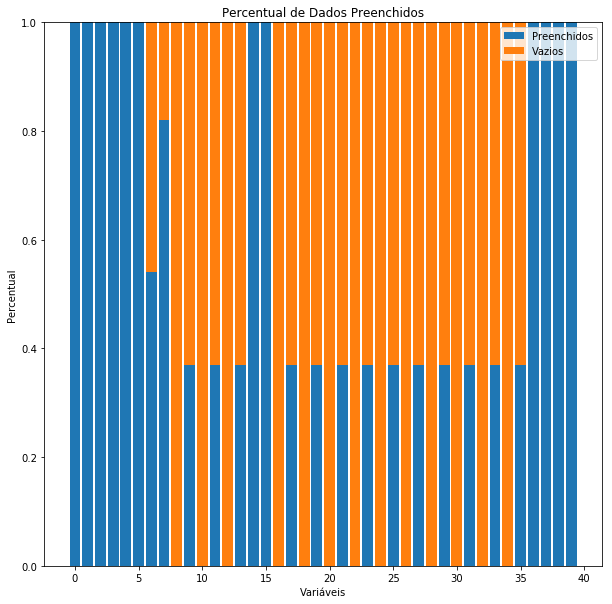

In [7]:
""" avaliando os valores nulos dentro da massa geral de dados"""
df_avaliando_nulos = pd.DataFrame(data = get_percentual_nulo(df), columns=['Perc. Vazio'])
df_avaliando_nulos['Perc. Preenchido'] = df_avaliando_nulos.apply(lambda x: 1 - x)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ind = np.arange(len(df_avaliando_nulos))
              
preenchidos = df_avaliando_nulos['Perc. Preenchido']
vazios = df_avaliando_nulos['Perc. Vazio']
width = 0.85

p1 = plt.bar(ind, preenchidos, width)
p2 = plt.bar(ind, vazios, width,bottom=preenchidos)

plt.rcdefaults()
plt.ylabel('Percentual')
plt.xlabel('Variáveis')
plt.title('Percentual de Dados Preenchidos')
plt.legend((p1[0], p2[0]), ('Preenchidos', 'Vazios'))
plt.show()

In [8]:
""" aplicando a primeira limpeza no df, eliminando as colunas 100% nulas """
colunas = []
for coluna in df.columns:
    qte_null = df[coluna].isnull().sum()
    perc_null = round(qte_null/len(df[coluna]), 2)
    
    if perc_null == 1.0:
        colunas.append(coluna)

# armazenando as colunas excluídas
arq_colunas_excluidas = open(join('Colunas100PorcentoNulas.txt'),"w")
arq_colunas_excluidas.write(str(colunas))
arq_colunas_excluidas.close()

# removendo as colunas do dataframe
df = df.drop(columns=colunas, axis=0)

In [9]:
# este bloco sera utilizado somente para restringir as oscs classificadas com mais de 1 area de atuacao
df.cd_area_atuacao = df.cd_area_atuacao.apply(int)
df = df[(df.cd_area_atuacao > 11)]

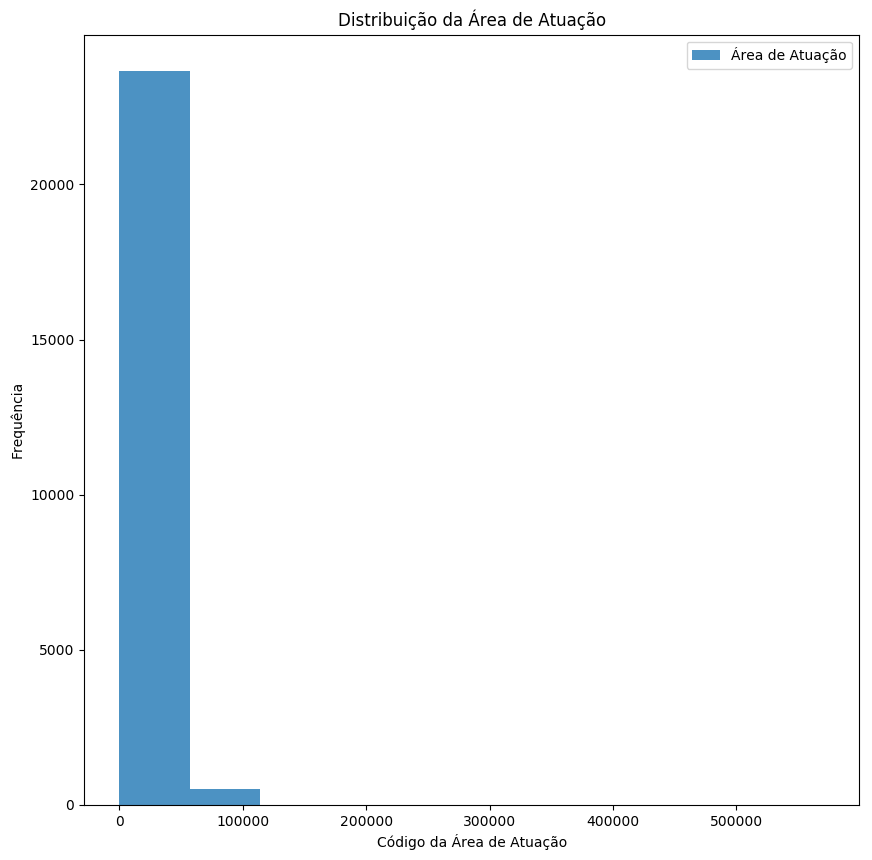

In [10]:
""" Avaliando a distribuição do código de área de atuação através de histrograma """

# plotando um histograma para avaliar a distribuição das áreas de atuação
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
 
ax.hist(df.cd_area_atuacao, label="Área de Atuação", alpha=.8)
 
ax.set(xlabel='Código da Área de Atuação',
       ylabel='Frequência',
       title='Distribuição da Área de Atuação')    

ax.legend(loc=1)

In [11]:
# Agrupando e contando a área de atuação
distribuicao = df.groupby('cd_area_atuacao').id_osc.count()
distribuicao

cd_area_atuacao
23            2
24           70
25          693
26          275
27            7
29          264
34           34
35          434
36            3
37           83
39          164
45         1139
46           57
47            8
49           36
56         1692
57          110
59        10123
67           12
79         2014
210          14
211          26
234           1
235           1
245          43
246           2
249           2
256          44
257           2
259         293
          ...  
511         875
567           4
579          53
710         499
711         246
2310          1
2456          3
2459          5
2510          2
2511         17
2710          4
3510          1
3511          2
3710         74
4510          1
4511          6
4710         21
5710        173
5711          1
6710         15
7910       3659
25710         1
35710         2
45710         1
56710         7
57910       183
71011       320
256710        3
257910        1
571011        7
Name: id

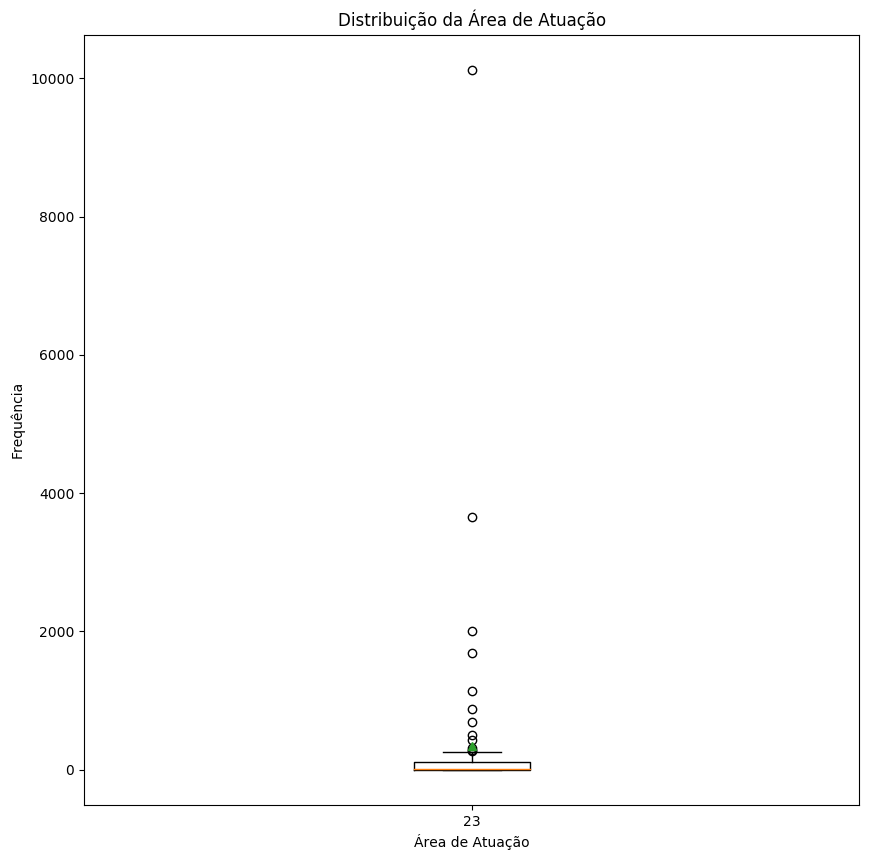

In [12]:
""" Avaliando a distribuição do código de área de atuação através de Boxplot """

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
 
ax.boxplot(distribuicao.values, showmeans=True, showfliers=True)
    
ax.set(xticklabels=distribuicao.index,
       xlabel='Área de Atuação',
       ylabel='Frequência',
       title='Distribuição da Área de Atuação')

In [13]:
""" avaliando pontualmente cada variável do df definindo a relevancia 
    - retirada ft_link_relatorio_auditoria pois só havia um tipo de registro e o restante nulo
    - retirada ft_link_demonstracao_contabil pois só havia um tipo de registro e o restante nulo
    - retirada bo_nao_possui_sigla_osc pois só havia um tipo de registro e o restante nulo
    - retirada bo_nao_possui_link_estatuto_osc pois só havia um tipo de registro e o restante nulo
    - retirada a coluna da código da sub área de atuação, pois é uma informação vinculada a área de atuação. """

colunas_removidas = ["id_osc","bo_nao_possui_sigla_osc","bo_nao_possui_link_estatuto_osc","dt_fundacao_osc"
                     ,"tx_razao_social_osc","tx_nome_fantasia_osc","ft_link_relatorio_auditoria","ft_link_demonstracao_contabil"
                     ,"ft_classe_atividade_economica_osc"]

colunas_texto = ["ft_natureza_juridica_osc","ft_link_estatuto_osc","ft_historico","ft_finalidades_estatutarias"
                 ,"ft_nome_responsavel_legal","ft_razao_social_osc","ft_nome_fantasia_osc","ft_logo","ft_missao_osc"
                 ,"ft_visao_osc","ft_fundacao_osc","ft_sigla_osc","ft_resumo_osc","ft_situacao_imovel_osc"
                 ,"ft_ano_cadastro_cnpj"]

# removendo as colunas do dataframe
df.drop(columns=colunas_removidas, axis=0, inplace=True)

# armazenando as colunas excluídas
arq_colunas_excluidas = open(join('ColunasRemovidasAposAvaliacao.txt'),"w")
arq_colunas_excluidas.write(str(colunas))
arq_colunas_excluidas.close()

In [14]:
# transformando as colunas de texto em número
transforma_colunas(colunas_texto,df)

# substituindo os valores nulos por -1
df.fillna(-1, inplace=True)

# convertendo todos os dados do df para int
print("\nConvertendo para int")
for col in df.columns:
    print(col)
    df[col] = df[col].apply(int)


Aplicando o LabelEncoder
ft_natureza_juridica_osc
ft_link_estatuto_osc
ft_historico
ft_finalidades_estatutarias
ft_nome_responsavel_legal
ft_razao_social_osc
ft_nome_fantasia_osc
ft_logo
ft_missao_osc
ft_visao_osc
ft_fundacao_osc
ft_sigla_osc
ft_resumo_osc
ft_situacao_imovel_osc
ft_ano_cadastro_cnpj

Convertendo para int
cd_area_atuacao
cd_natureza_juridica_osc
ft_natureza_juridica_osc
ft_razao_social_osc
ft_nome_fantasia_osc
ft_logo
ft_missao_osc
ft_visao_osc
ft_fundacao_osc
ft_ano_cadastro_cnpj
ft_sigla_osc
ft_resumo_osc
ft_situacao_imovel_osc
ft_link_estatuto_osc
ft_historico
ft_finalidades_estatutarias
ft_nome_responsavel_legal
cd_classe_atividade_economica_osc


In [15]:
""" criando uma matriz com a correlação entre todas as variáveis do df """
dim = df.shape[1]
matrix = [[0]*dim for i in range(dim)]
for i in range(dim):
    for j in range(dim):
        matrix[i][j] = df.iloc[:,i].corr(df.iloc[:,j])

df_matrix = pd.DataFrame(matrix, columns=df.columns, index=df.columns)

In [16]:
""" identificando as correlações acima de 0.9 ou menores de -0.9 e removendo as colunas do df """
colunas_alto_nivel_corr = []
arquivo_colunas_removidas = open("Colunas Removidas Devido Alto Nivel de Correlacao.txt", "w")

for linha, valor in df_matrix.iterrows():
    for coluna in df_matrix.columns:
        if linha == coluna:
            continue
        
        if valor[coluna] >= 0.9 or valor[coluna] <= -0.9:
            tx = "Correlação entre: {:s} e {:s} = {:f} \n".format(linha,coluna,valor[coluna])
            arquivo_colunas_removidas.write(tx)
            colunas_alto_nivel_corr.append(coluna)

arquivo_colunas_removidas.close()
df.drop(columns=set(colunas_alto_nivel_corr), inplace=True)

# Separando os dados de teste e treino

In [17]:
""" separando os dados de treino e teste em 70% para treino e 30% para teste"""

X_treino, X_teste, y_treino, y_teste = train_test_split(df, df.cd_area_atuacao, test_size=0.3)

# retirando a variável de resposta do df de treino e teste
X_treino = X_treino.iloc[:,1:]
X_teste = X_teste.iloc[:,1:]

print(X_treino.shape, y_treino.shape)
print(X_teste.shape, y_teste.shape)

(16911, 6) (16911,)
(7248, 6) (7248,)


# Treinando o algoritmo random forest

In [18]:
""" treinando o modelo de classificação utilizando o algoritmo RandomForestClassifier da biblioteca sklearn """

rf = RandomForestClassifier(n_estimators= 200, min_samples_split = 10, min_samples_leaf = 2, 
                            max_features = 'sqrt', max_depth = 50, bootstrap = True)

rf.fit(X_treino, y_treino)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf='deprecated', n_estimators=200,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
# avaliando o score nos dados de treino
rf.score(X_treino, y_treino)

0.7093607710957365

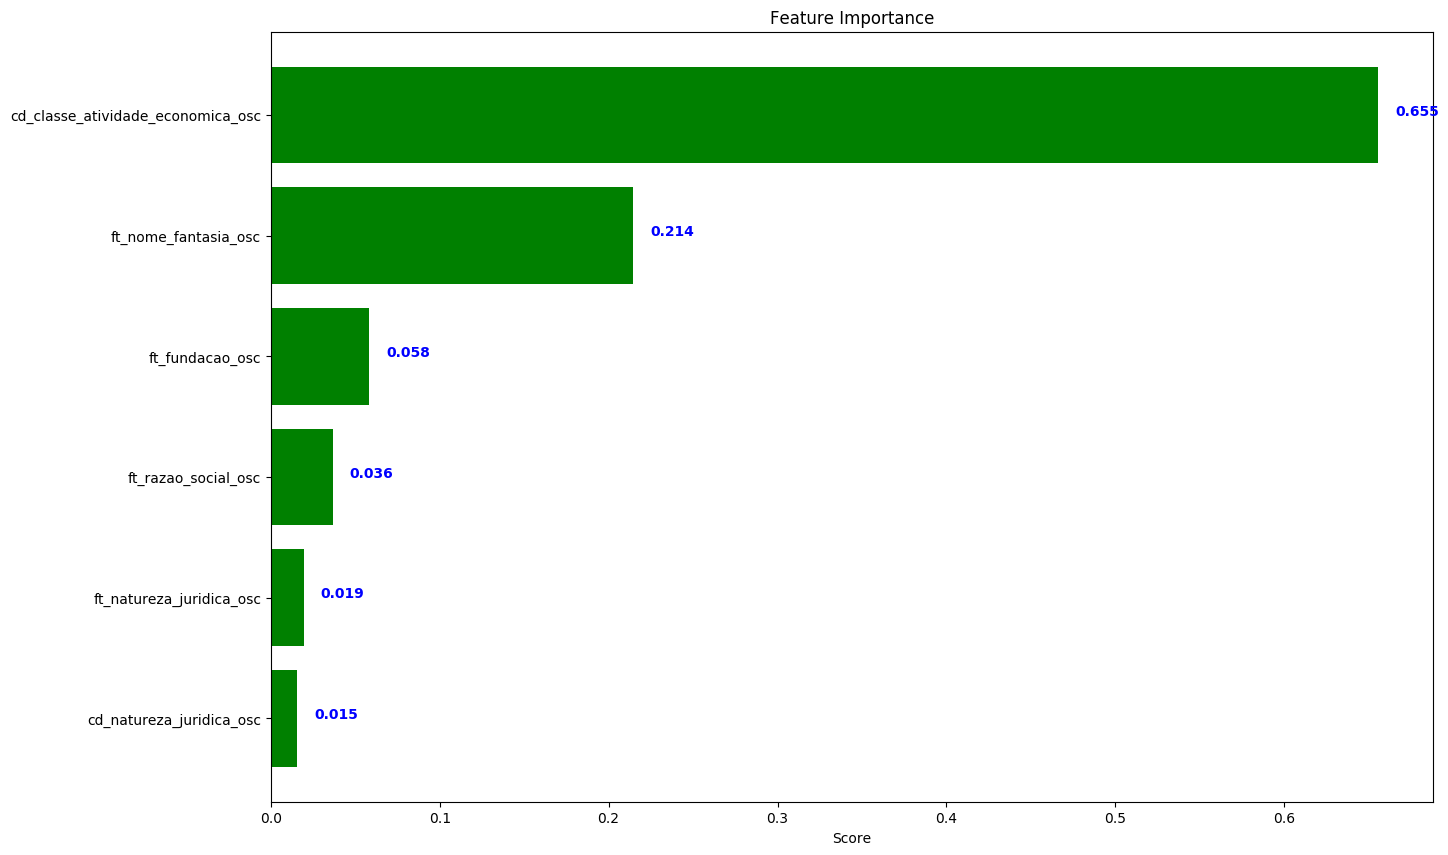

In [20]:
# avaliando a importancia das variáveis
importances = rf.feature_importances_
dic_fi = {}
i = 0
for coluna in X_teste.columns:
    dic_fi[coluna] = importances[i]
    i+=1

# ordernando dicionário de forma descrecente pelo valor
dic_fi = [(k, dic_fi[k]) for k in sorted(dic_fi, key=dic_fi.get, reverse=True)]

# separando os labels e valores
lista_labels = []
lista_valores = []

for label,valor in dic_fi:
    lista_labels.append(label)
    lista_valores.append(valor)

lista_labels = tuple(lista_labels)
lista_valores = tuple(lista_valores)


# plotando a importância das variáveis
np.random.seed(2)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(15,10))

colunas = lista_labels
y_pos = np.arange(len(colunas))

ax.barh(y_pos, lista_valores,color='green')

ax.set_yticks(y_pos)
ax.set_yticklabels(colunas)
ax.invert_yaxis()
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

for i, v in enumerate(lista_valores):
    ax.text(v+0.01, i , str(v)[:5], color='blue', fontweight='bold')

plt.show()

# Testando o algoritmo random forest

In [21]:
# aplicando a predição nos dados de teste
predicao = rf.predict(X_teste)

[[  0   0   0 ...   0   0   0]
 [  0   8   0 ...   0   0   0]
 [  0   0 139 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0  31   0]
 [  0   0   0 ...   0   0   0]]


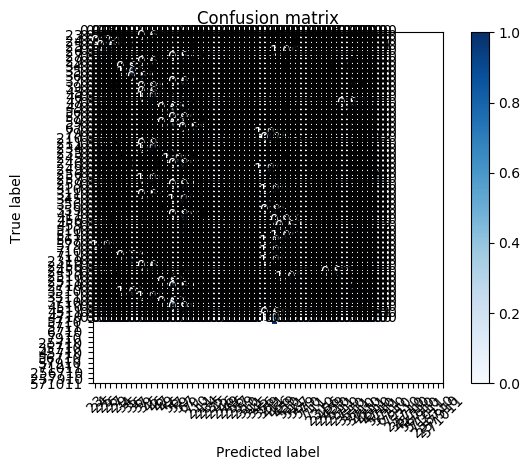

In [22]:
# criando a matrix de confusão para avaliar o resultado
matrix_confusao = confusion_matrix(y_teste,predicao)
print(matrix_confusao)
plot_confusion_matrix(matrix_confusao,distribuicao.index, normalize=True)

In [23]:
d_matriz = pd.DataFrame(matrix_confusao)
d_matriz.to_html("matriz_confusao_mais_de_uma_area.html")

In [24]:
# utilizando para verificar a performance do modelo para dados desnormalizados
print("Acurácia:",accuracy_score(y_teste, predicao))
print("MCC:", matthews_corrcoef(y_teste, predicao))
print("Macro:",f1_score(y_teste, predicao, average="macro"))
print("Micro:",f1_score(y_teste, predicao, average="micro"))

Acurácia: 0.706953642384106
MCC: 0.6138452321845839
Macro: 0.2158354064133609
Micro: 0.706953642384106
